#1. 데이터 준비, 전처리

In [ ]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 39.2 MB/s eta 0:00:00


In [ ]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 69.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import konlpy
from konlpy.tag import Okt
import tqdm
import time

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/알라딘 베스트셀러 Top 1000 1999~2024/가공 데이터/추천서비스_최종데이터(10.26).csv"
df_original = pd.read_csv(path, encoding = 'utf=8=sig',  dtype = {"ISBN" : 'str'})
df = df_original.copy()

#2. LDA 분석에 쓸 description_nouns 만드는 과정 (description_nouns)

In [ ]:
import re
pd.options.mode.chained_assignment = None  # default='warn'

text = df.loc[34002, 'description_naver']
text1 = re.sub(r'[^\w\s가-힣]', ' ', text)
text1 = re.sub(r'[\n\d]',' ', text1)


#형태소 분석 후 명사 중 불용어에 포함되지 않은 것만 저장
Okt = konlpy.tag.Okt()
#불용어 사전
stopword_data_path = '/content/drive/MyDrive/알라딘 베스트셀러 Top 1000 1999~2024/가공 데이터/stopwords-ko.txt'
with open(stopword_data_path, 'r', encoding='utf-8') as f:
  stopwords = [line.strip() for line in f.readlines()]

def process_okt(text):
  Okt_morphs = Okt.pos(text)
  return ' '.join([word for word, pos in Okt_morphs if pos == 'Noun'])

def process_stop(text):
  Okt_morphs = Okt.pos(text)
  return ' '.join([word for word, pos in Okt_morphs if word not in stopwords])

def process_one(text):
  Okt_morphs = Okt.pos(text)
  return ' '.join([word for word, pos in Okt_morphs if len(word) > 1])


text2 = process_okt(text1)
text3 = process_one(text2)
text3

'식물 신세 지고 식물 대한 이야기 조금 당신 식물 추천 인생 가장 대상 러브레터 마음 다해 식물 친구 이제껏 이타 존재 사랑 본문 조금 당신 식물 추천 식물 애호가 식물 이해 순간 기록 에세이 초보 가드 시절 현재 성장 기록 편의 식물 존재 로부터 위로 마음 노력 공유 멍하니 순간 상처 치유 식물 추천 사람 반려동물 자신 친구 회사 책상 지인 마음 누군가 존재 친구 식물 통해 식물 세상 괴로움 시간 고백 식물 가기 하나 움직임 생명 반복 식물 존재 통해 기쁨 즐거움 위로 신발 신고 순간 잠시 성장 초록 존재 위안 식물 시작 고민 다짐 순간 식물 선택 자신 인정 식물 생명 성장 주위 생명 방치 생명 눈길 통해 결심 방향 고백'

In [ ]:
#네이버 알라딘 상세설명 둘 다 없는거 드랍
df = df[~(df['description_aladin'].isnull() & df['description_naver'].isnull())]

#네이버 상세설명 특수문자 등 전처리
df['description_naver'] = df['description_naver'].str.replace(pat=r'[^\w\s가-힣]', repl=r' ', regex=True)
df['description_naver'] = df['description_naver'].str.replace(pat=r'[\n\d]', repl=r' ', regex=True)
#알라딘 상세설명 전처리
df['description_aladin'] = df['description_aladin'].str.replace(pat=r'[^\w\s가-힣]', repl=r' ', regex=True)
df['description_aladin'] = df['description_aladin'].str.replace(pat = r'[&lt&gt]', repl=r'', regex=True)

#네이버 비었으면 알라딘 넣기
df['description_naver'] = df['description_naver'].fillna(df['description_aladin'])

In [ ]:
#형태소 분석 후 명사 중 불용어에 포함되지 않은 것만 저장
Okt = konlpy.tag.Okt()
pd.options.mode.chained_assignment = None  # default='warn'

#불용어 사전
stopword_data_path = r'C:\Users\Hane\Downloads\졸업 프로젝트/stopwords-ko.txt'
#불용어 제거 전 dictionary length : 100000 (사실상 초과)
#불용어 제거 후 dictionary length : 34062
with open(stopword_data_path, 'r', encoding='utf-8') as f:
  stopwords = [line.strip() for line in f.readlines()]

def process_text(text):
  Okt_morphs = Okt.pos(text)
  return ' '.join([word for word, pos in Okt_morphs if pos == 'Noun' and word not in stopwords and len(word)>1])

df['description_nouns'] = df['description_naver'].apply(lambda x : process_text(x))

#3. LDA 학습

In [ ]:
#토큰화
doc = df['description_nouns'].apply(lambda x : x.split()).tolist()

#딕셔너리
dictionary = corpora.Dictionary(doc)
dictionary.filter_extremes(no_below=3, no_above=0.5)

#doc2bow 말뭉치
corpus = [dictionary.doc2bow(text) for text in doc]

In [ ]:
coherence_score = []
perplexity_score = []

ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word = dictionary,
                                           num_topics = 30,
                                           chunksize = 30000,
                                           passes = 15,
                                           iterations = 10,
                                           alpha = 'auto',
                                           eta = 'auto',
                                          )
coherence_model = CoherenceModel(model = ldamodel,
          texts = doc, dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model.get_coherence()
perplexity_lda = ldamodel.log_perplexity(corpus)

print("Coherence Score : ", coherence_lda)
print("Perplexity Score : ", perplexity_lda)

In [ ]:
#gensim LDA는 한 번 들어온 Chunk가 문서의 전체 길이인 것으로 파악하게 된다 : chunk는 최대한 많이.
CHUNKSIZE = 30000  #한번에 트레이닝 처리할 corpus 문서의 개수
PASSES = 15         #첫 chunk부터 마지막 chunk까지 학습 반복 횟수.
ITERATIONS = 10    #문서 당 반복 횟수

coherence_score = []
perplexity_score = []

start_time = time.time()
ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word = dictionary,
                                           num_topics = 30,
                                           chunksize = CHUNKSIZE,
                                           passes = PASSES,
                                           iterations = ITERATIONS,

                                           alpha = 'auto', #문서 내 토픽분포.낮으면 적은 수의 토픽에, 높으면 많은 수의 토픽에 집중
                                           eta = 'auto', #토픽 내 단어분포.낮으면 적은 수의 단어에, 높으면 많은 수의 단어가 포함.
                                          )
coherence_model = CoherenceModel(model = ldamodel, texts = doc, dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model.get_coherence()
perplexity_lda = ldamodel.log_perplexity(corpus)
print("Coherence Score : ", coherence_lda)
print("Perplexity Score : ", perplexity_lda)

end_time = time.time()
print(f"전체 실행 시간 : {end_time - start_time:.2f}초")

Coherence Score :  0.5089698737968849
Perplexity Score :  -8.119840468786272
전체 실행 시간 : 315.43초


In [ ]:
#저장 불러오기
from gensim.corpora import MmCorpus
from gensim.corpora import Dictionary

ldamodel.save('lda_model.model')
dictionary.save('dictionary.dict')
MmCorpus.serialize('corpus.mm', corpus)

#ldamodel.load('lda_model.model')
#dictionary = Dictionary.load('dictionary.dict')
#corpus = MmCorpus('corpus.mm')

In [ ]:
import pyLDAvis.gensim_models

# 시각화 데이터 준비
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=False)

# Jupyter Notebook 환경에서 시각화
pyLDAvis.enable_notebook()  # 노트북에 바로 출력
pyLDAvis.display(lda_display)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#4. 실험 (발표 그래프용)

In [ ]:
import gensim
from gensim.models import CoherenceModel

def lda_co_per_test(CHUNKSIZE, PASSES, ITERATIONS):
    print(f"chunk={CHUNKSIZE}, pass={PASSES}, iter={ITERATIONS}.txt")
    f = open(f"/content/drive/MyDrive/도서분석 AI 용 데이터/chunk={CHUNKSIZE}, pass={PASSES}, iter={ITERATIONS}.txt", "w")

    start_time = time.time()
    coherence_score = []
    perplexity_score = []

    for i in range(10,101,10):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                                   id2word = dictionary,
                                                   num_topics = i,

                                                   chunksize = CHUNKSIZE,
                                                   passes = PASSES,
                                                   iterations = ITERATIONS,
                                                   alpha = 'auto', #문서 내 토픽분포.낮으면 적은 수의 토픽에, 높으면 많은 수의 토픽에 집중
                                                   eta = 'auto', #토픽 내 단어분포.낮으면 적은 수의 단어에, 높으면 많은 수의 단어가 포함.
                                                   )
        coherence_model = CoherenceModel(model = ldamodel, texts = doc, dictionary = dictionary, coherence = 'c_v')
        coherence_lda = coherence_model.get_coherence()
        perplexity_lda = ldamodel.log_perplexity(corpus)

        print(i, "Coherence Score : ", coherence_lda)
        print(i, "Perplexity Score : ", perplexity_lda)
        f.write(f"{i}, Coherence Score : {coherence_lda}, Perplexity Score : {perplexity_lda}\n")

        coherence_score.append(coherence_lda)
        perplexity_score.append(perplexity_lda)

    end_time = time.time()
    print(f"전체 실행 시간 : {end_time - start_time:.2f}초")
    f.close()

In [ ]:
#chunksize, passes, iterations
#for c in [25000, 30000]:
 #   for p in [10, 15, 20]:
  #      for i in [5, 10]:
   #         lda_co_per_test(c, p, i)

#25000, 5, 5 - warning (pass, iter 너무 작음)

chunk=25000, pass=10, iter=5.txt
10 Coherence Score :  0.4675320428569025
10 Perplexity Score :  -8.10589877021513
20 Coherence Score :  0.5170857680976231
20 Perplexity Score :  -8.207635765794691
30 Coherence Score :  0.4890494500488128
30 Perplexity Score :  -8.354012298501948
40 Coherence Score :  0.48346855003823686
40 Perplexity Score :  -8.479159321592581
50 Coherence Score :  0.48235720285017114
50 Perplexity Score :  -8.623695352119022
60 Coherence Score :  0.4790411175334629
60 Perplexity Score :  -8.761430399652987
70 Coherence Score :  0.4765511278596327
70 Perplexity Score :  -8.873805220591198
80 Coherence Score :  0.4591672348819273
80 Perplexity Score :  -9.011821456043416
90 Coherence Score :  0.4672953696756096
90 Perplexity Score :  -9.129175923844258
100 Coherence Score :  0.48800366956559366
100 Perplexity Score :  -9.237715447593402
전체 실행 시간 : 2496.75초
chunk=25000, pass=10, iter=10.txt
10 Coherence Score :  0.5118804978983802
10 Perplexity Score :  -8.020660852353

KeyboardInterrupt: 

In [ ]:
#lda_co_per_test(25000, 15, 5)
#lda_co_per_test(25000, 15, 10)
#lda_co_per_test(25000, 20, 5)
#lda_co_per_test(25000, 20, 10)

chunk=25000, pass=15, iter=5.txt
10 Coherence Score :  0.5072608061836912
10 Perplexity Score :  -8.08573554633422
20 Coherence Score :  0.5211500810563677
20 Perplexity Score :  -8.191763306312943
30 Coherence Score :  0.5024284895401929
30 Perplexity Score :  -8.318315860777613
40 Coherence Score :  0.49015100136836454
40 Perplexity Score :  -8.437400774664447
50 Coherence Score :  0.5103596296781646
50 Perplexity Score :  -8.58512186182139
60 Coherence Score :  0.5053527669641978
60 Perplexity Score :  -8.708256245036027
70 Coherence Score :  0.4783109982680858
70 Perplexity Score :  -8.847056239075796
80 Coherence Score :  0.49503834262556656
80 Perplexity Score :  -8.941190390571201
90 Coherence Score :  0.4909808043944698
90 Perplexity Score :  -9.072550048346871
100 Coherence Score :  0.48325860683462635
100 Perplexity Score :  -9.177769733911928
전체 실행 시간 : 4153.82초
chunk=25000, pass=15, iter=10.txt
10 Coherence Score :  0.5045652655745914
10 Perplexity Score :  -7.9997008304656

In [ ]:
#chunksize, passes, iterations
#for c in [30000]:
#    for p in [10, 15, 20]:
#        for i in [5, 10]:
#            lda_co_per_test(c, p, i)


chunk=30000, pass=10, iter=5.txt
10 Coherence Score :  0.5291416138281522
10 Perplexity Score :  -8.088978028985064
20 Coherence Score :  0.5108340038916868
20 Perplexity Score :  -8.178328019077265
30 Coherence Score :  0.4885577980371944
30 Perplexity Score :  -8.329262454618116
40 Coherence Score :  0.4862026675339255
40 Perplexity Score :  -8.451903520690134
50 Coherence Score :  0.46733973311434485
50 Perplexity Score :  -8.60615968359197
60 Coherence Score :  0.4636750508266207
60 Perplexity Score :  -8.710196766174434
70 Coherence Score :  0.4718558585207993
70 Perplexity Score :  -8.826708252353765
80 Coherence Score :  0.4824069764074933
80 Perplexity Score :  -8.933587459416282
90 Coherence Score :  0.49217267020634525
90 Perplexity Score :  -9.045329911662652
100 Coherence Score :  0.47490497614131416
100 Perplexity Score :  -9.152670749319132
전체 실행 시간 : 3018.57초
chunk=30000, pass=10, iter=10.txt
10 Coherence Score :  0.5245409928476328
10 Perplexity Score :  -8.039963722389

#그래프 그리기

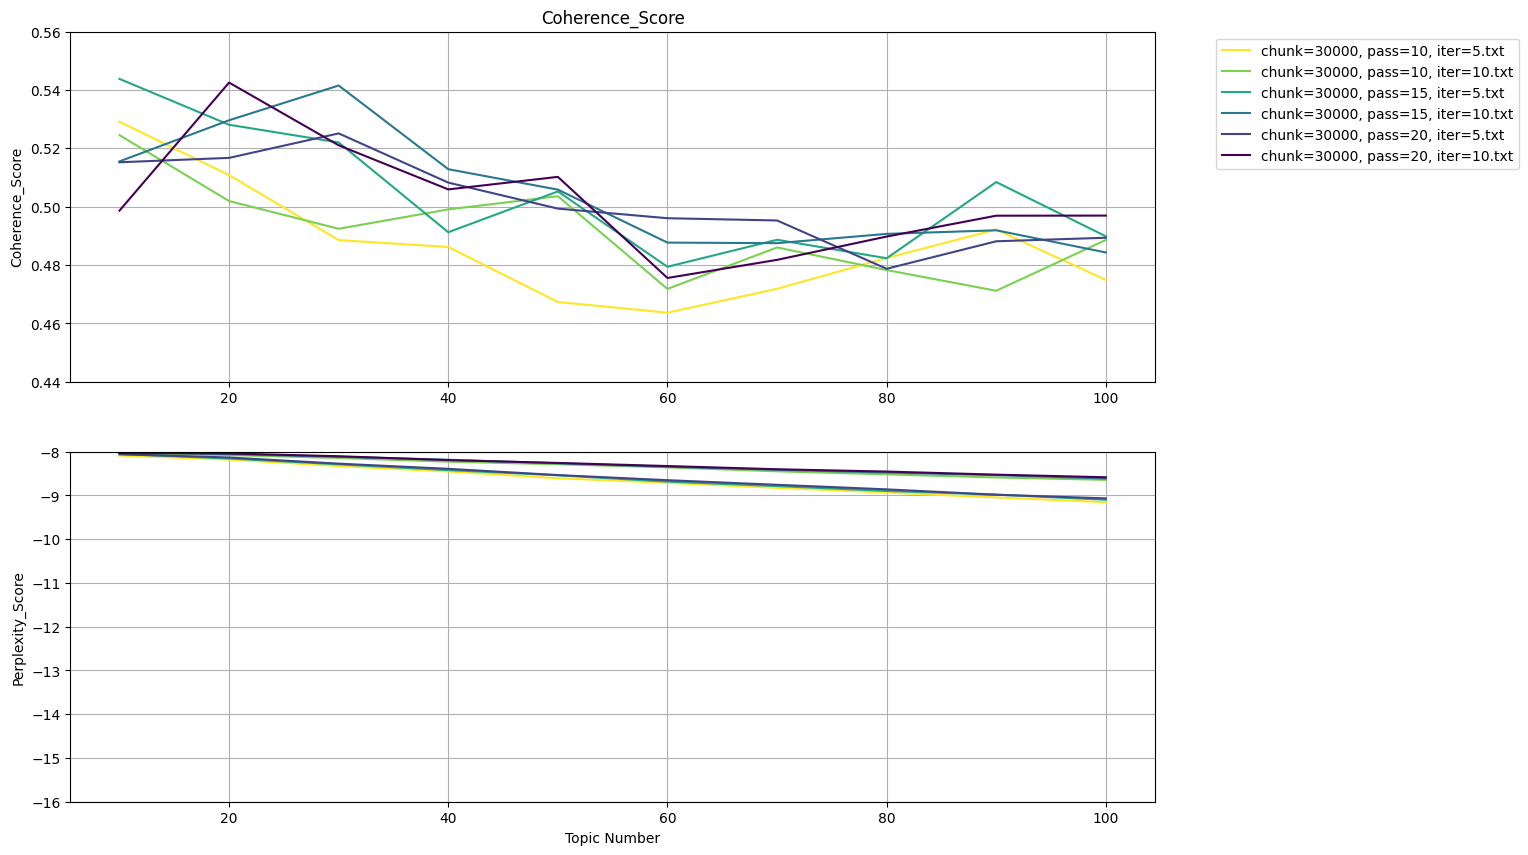

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

folder_path = '/content/drive/MyDrive/도서분석 AI 용 데이터/LDA co, per 결과들'  # Replace with the actual folder path

data = {}
titles = []

for file in os.listdir(folder_path):
    if file.endswith(".txt") & ("chunk=30000" in file):
        file_path = os.path.join(folder_path, file)
        data[file] = {'topic_num' : [], 'coherence_score' : [], 'perplexity_score' : []}
        titles.append(file)

        with open(file_path, 'r') as f:
            for line in f:
                parts = line.split(", ")
                if len(parts) == 3:
                    topic_num = int(parts[0])
                    coherence_score = float(parts[1].split(": ")[1])
                    perplexity_score = float(parts[2].split(": ")[1])

                    #데이터 저장
                    data[file]['topic_num'].append(topic_num)
                    data[file]['coherence_score'].append(coherence_score)
                    data[file]['perplexity_score'].append(perplexity_score)


colors = plt.cm.viridis_r(np.linspace(0, 1, len(titles)))
fig, axs = plt.subplots(2, 1, figsize=(14, 10))  # 1행 2열 서브플롯

for i, k in enumerate(titles):
  axs[0].plot(data[k]['topic_num'], data[k]['coherence_score'], color=colors[i], linestyle = '-', label = k)

axs[0].set_title('Coherence_Score')
axs[0].set_ylabel('Coherence_Score')
axs[0].set_ylim(0.44, 0.56)
axs[0].grid()

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for i, k in enumerate(titles):
  axs[1].plot(data[k]['topic_num'], data[k]['perplexity_score'], color=colors[i], linestyle = '-')
axs[1].set_xlabel('Topic Number')
axs[1].set_ylabel('Perplexity_Score')
axs[1].set_ylim(-16, -8)
axs[1].grid()

plt.show()

#coherence score 제일 높은 값 선정
#perplexity는 그냥 토픽수가 증가함에 따라 비례해서 낮아지기 때문에 신경 쓰지 않음. 하지만 너무 많은 토픽수는 과적합을 유발할 수 있으니 주의
#토픽 수 20-40개가 적당할 것으로 판단

#chunk=5000, 10000 : 토픽 수가 늘어남에 따라 응집도가 줄어들고 혼잡도도 급격하게 줄어 사용 안함


In [ ]:
titles

['chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=5.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=5, iter=10.txt',
 'chunk=15000, pass=10, iter=5.txt',
 'chunk=15000, pass=10, iter=5.txt',
 'chunk=15000, pass=10, iter=5.txt',
 'chunk=15000, pass=10, iter=5.txt',
 'chunk=15000, pass=10, iter=5.txt',
 'chunk=15000, pass=10, iter=5.txt',
 'chunk=15000, pass=10, iter=5.txt',
 'chunk=150